In [1]:
# Import packages
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import requests
import rasterio
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
import mercantile as m
from shapely.geometry import shape, Polygon, Point, box
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from zipfile import ZipFile
import shutil

# NOTE: change to your own path when setting workspace
ws = r'C:\Users\emers\.rainfall'
# ws = r'C:\Users\sgartrel\Desktop\geog490\final-proj\RainfallCollection\data'


C:\Users\emers\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Step 1: Get Data
Download vector data for the state geometry and the geometry of buildings within it, and store these datasets in geodataframes. The vector data can be downloaded for any US State that you have a precipitation cdf for--just manipulate the `state` variable in the following code cell.

##### References:
- [Global Footprints Dataset](https://github.com/microsoft/GlobalMLBuildingFootprints)
- [Unzip files in python (geeks for geeks)](https://www.geeksforgeeks.org/unzipping-files-in-python/)

In [2]:
# set target state
state = 'arizona'

# get state bounds
state_gdf = gpd.read_file(
    f'https://raw.githubusercontent.com/glynnbird/usstatesgeojson/master/{state}.geojson', crs='epsg:32612'
)

In [3]:
# get building data
filename = f'{state.title()}.geojson.zip'
filepath = os.path.join(ws, filename)
url = f'https://usbuildingdata.blob.core.windows.net/usbuildings-v2/{filename}'

with requests.get(url, allow_redirects=True, stream=True) as r:
    with open(filepath, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
        print('zip downloaded')

        with ZipFile(filepath, 'r') as z:
            z.extractall(
                path=ws
                )

print(f'file unzipped successfully ({os.path.getsize(filepath.strip(".zip")) / 1000000} MB)')

zip downloaded
file unzipped successfully (845.767832 MB)


In [4]:
# read buildings into geojson
buildings_gdf = gpd.read_file(filepath.strip('.zip'), crs='epsg:4326')
buildings_gdf.to_crs('epsg:32612')
print('read into dataframe successfully')

read into dataframe successfully


### Step 2: Prep the NC file
Remove some dimensions and summarize across the `time` attribute to preview
- `max` precip in the timespan
- `min` precip in the timespan
- `mean` precip among the timespan

##### References:
- [dropping the `expver` variable](https://code.mpimet.mpg.de/boards/1/topics/8961)

In [5]:
# load precip data
xds = xr.open_dataset(os.path.join(ws, 'precip.nc'))

# drop the "expver" dimension
no_expver = xds.reduce(np.nansum, dim='expver')

# get mean, max, min precipitation over the 10 year period
mean = no_expver.reduce(np.mean, dim='time', keep_attrs=True)
max = no_expver.reduce(np.max, dim='time', keep_attrs=True)
min = no_expver.reduce(np.min, dim='time', keep_attrs=True)

# verify time dimension has been removed from each
for i in [max, mean, min]:
    assert 120 not in i.to_array().shape 

mean_df = mean.to_dataframe()
max_df = max.to_dataframe()
min_df = min.to_dataframe()

print(mean_df.tail(5))
print(max_df.tail(5))
print(min_df.tail(5))


                          tp
longitude latitude          
-108.0    32.00     0.000645
          31.75     0.000628
          31.50     0.000587
          31.25     0.000650
          31.00     0.000684
                          tp
longitude latitude          
-108.0    32.00     0.003283
          31.75     0.003353
          31.50     0.003656
          31.25     0.004519
          31.00     0.004999
                     tp
longitude latitude     
-108.0    32.00     0.0
          31.75     0.0
          31.50     0.0
          31.25     0.0
          31.00     0.0


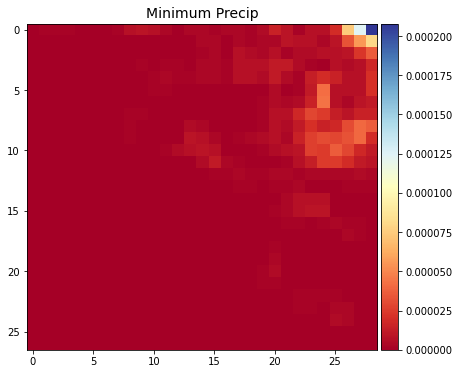

In [6]:
# Plot Minimums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(min.to_array()[0], cmap='RdYlBu')
ax.set_title("Minimum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

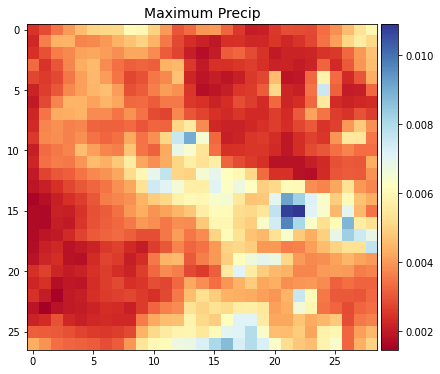

In [7]:
# Plot Maximums
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(max.to_array()[0], cmap='RdYlBu')
ax.set_title("Maximum Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

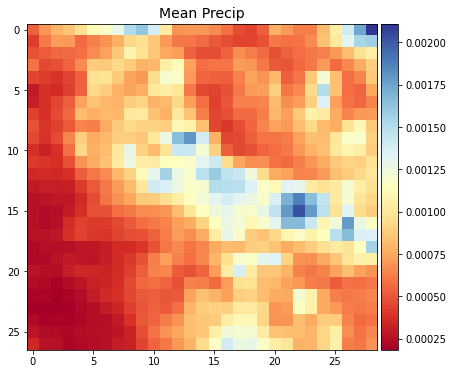

In [8]:
# Plot Means
fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(mean.to_array()[0], cmap='RdYlBu')
ax.set_title("Mean Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

### Step 3: Reproject and Read into Rasterio
As you can see from the axes of the above plots, the cdf file is still in degrees that count up from its corners, so it appears unaware of its location. Creating a spatially-aware raster is necessary before analysis can be perfomed between buildings and precip

In [10]:
#precip.close()
#precip_raster.close()

# Converts the NC file with precipitation data to A Raster
#no_expver.rio.write_crs('EPSG:4326', inplace=True)
# no_expver.rio.reproject('EPSG:32612')


precip = no_expver['tp']
precip = precip.rio.set_spatial_dims(x_dim='latitude', y_dim='longitude')
reordered = precip.transpose('time', 'latitude', 'longitude')
reordered.rio.write_crs('EPSG:4326', inplace=True) #4326

reordered_new = reordered.rio.reproject('EPSG:32612')
reordered_new.rio.to_raster(os.path.join(ws, 'precip_raster.tiff'))

C:\Users\emers\anaconda3\lib\site-packages\rioxarray\raster_writer.py:132: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


EPSG:32612


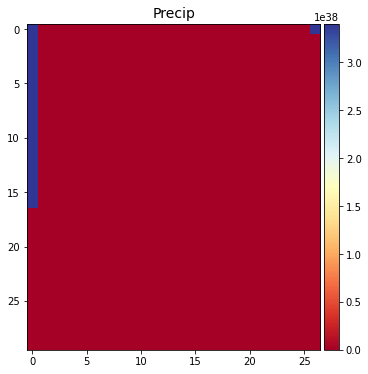

In [11]:
# Opens raster created in last cell
precip_raster = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))  
print(precip_raster.crs)

# Reads the raster with the band representing the month, 1 being Jan. 2013
precip_array = precip_raster.read(1)

fig, ax = plt.subplots(figsize=(10,6))
im1 = ax.imshow(precip_array, cmap='RdYlBu')

ax.set_title("Precip", fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

In [12]:
# clip buildings (for speedy development)
test = gpd.read_file(
    os.path.join(ws, 'test.geojson'),
    crs='epsg:4326'
    ).to_crs(
    'epsg:32612'
    )

subset = gpd.clip(buildings_gdf.to_crs('epsg:32612'), test)

In [13]:
# set bldg = buildings_gdf for complete analysis
# bldg = subset
bldg = buildings_gdf
precip = rasterio.open(os.path.join(ws, 'precip_raster.tiff'))

bldg = bldg.to_crs('epsg:32612') # 4326 necessary due to GDAL driver drama. Area is still accurate bc derived from UTM

# add necesasry fields to building data
bldg['area_m2'] = bldg['geometry'].area

bldg['centroid'] = bldg['geometry'].centroid


C:\Users\emers\anaconda3\lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


epsg:32612 EPSG:32612


C:\Users\emers\anaconda3\lib\site-packages\matplotlib\image.py:491: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


<AxesSubplot: >

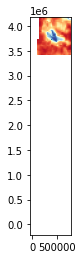

In [14]:
# this step takes about an hour for the full building dataset

from rasterio.plot import show

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[precip.bounds[0], precip.bounds[2], precip.bounds[1], precip.bounds[3]]
ax = rasterio.plot.show(precip, extent=extent, ax=ax, cmap='RdYlBu')
state_precip = state_gdf.boundary.plot(ax=ax)
print(bldg.crs, precip.crs)


coord_list = [(x,y) for x,y in zip(bldg['centroid'].x , bldg['centroid'].y)]
bldg['precip_m'] = [x for x in precip.sample(coord_list)]
bldg.plot(ax=state_precip)

### Step 4: Do Some Actual Analysis
Now that the raster is georeferenced and its values have been successfully ported to the geodataframe, we can begin summarizing and drawing conclusions about the state's rainwater harvesting potential. Some facts to note:
- AZ'  driest month: June
- AZ's wettest month: March
- AZ's monsoon season: June-September
- Rainfall is measured in meters for this dataset
    - the base area of any rain gauge is linearly related to how much rain it catches, meaning that precip data in meters can be simultaneously interpreted as mm per square meter/foot/mile/etc. 

The process:
- First, we filter out buildings that are too big to count as residential houses, a subjective threshold we've defined as 200 square meters.
- Then, we summarize precipitation data spanning the 10 year period for each building, in terms of harvest amounts (m3)

#### References:
- [Arizona Weather](https://www.rssweather.com/climate/Arizona/Phoenix/#:~:text=The%20driest%20month%20in%20Phoenix,March%20is%20the%20wettest%20month.)

In [15]:
# this cell takes about 3 minutes for the full dataset
# define parameters (area threshold in meters, daily residential usage in gallons)
residential_roof = 200
residential_usage = 146

# drop non-residential sized buildings and get water usage in cubic meters/month (converted from gallons per day)
bldg = bldg[bldg['area_m2'] <= residential_roof]
bldg['usage_m3'] = (residential_usage * 30 * 3.78541) / 1000

# summarize the precip array
bldg['mean_precip_m'] = bldg['precip_m'].apply(lambda x: np.mean(x))
bldg['min_precip_m'] = bldg['precip_m'].apply(lambda x: np.min(x))
bldg['max_precip_m'] = bldg['precip_m'].apply(lambda x: np.max(x))

# get harvest values in cubic meters
bldg['mean_harvest_m3'] = bldg['mean_precip_m'] * bldg['area_m2']
bldg['min_harvest_m3'] = bldg['min_precip_m'] * bldg['area_m2']
bldg['max_harvest_m3'] = bldg['max_precip_m'] * bldg['area_m2']

# average the 3rd month of every year in 120 months
bldg['mar_precip'] = bldg['precip_m'].apply(lambda x: np.mean(
    [
        x[month] for month in range(3, (len(x)-1), 12)
    ]
))

# average the 6th month of every year in 120 months
bldg['jun_precip'] = bldg['precip_m'].apply(lambda x: np.mean(
    [
        x[month] for month in range(6, (len(x)-1), 12)
    ]
))

# average monsoon season (6th - 9th month every year)


bldg

C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,release,capture_dates_range,geometry,area_m2,centroid,precip_m,usage_m3,mean_precip_m,min_precip_m,max_precip_m,mean_harvest_m3,min_harvest_m3,max_harvest_m3,mar_precip,jun_precip
0,1,,"POLYGON ((674547.990 4077362.675, 674550.363 4...",188.139028,POINT (674548.797 4077375.595),"[0.0009784424, 0.0003987113, 0.00034337165, 0....",16.580096,0.000707,0.000000,0.003231,0.133005,0.000000,0.607882,0.000469,0.000841
1,1,,"POLYGON ((677061.700 3947958.682, 677050.666 3...",81.687574,POINT (677054.370 3947963.541),"[0.0011691302, 0.00070191175, 0.0003987113, 0....",16.580096,0.001023,0.000025,0.003475,0.083582,0.002029,0.283882,0.000575,0.001922
2,1,,"POLYGON ((677035.449 3947903.450, 677045.919 3...",196.629991,POINT (677041.866 3947910.534),"[0.0011691302, 0.00070191175, 0.0003987113, 0....",16.580096,0.001023,0.000025,0.003475,0.201190,0.004884,0.683333,0.000575,0.001922
3,1,,"POLYGON ((676907.013 3948013.310, 676903.527 3...",62.588885,POINT (676901.138 3948008.144),"[0.0011691302, 0.00070191175, 0.0003987113, 0....",16.580096,0.001023,0.000025,0.003475,0.064040,0.001554,0.217510,0.000575,0.001922
4,1,,"POLYGON ((676893.096 3948070.961, 676887.936 3...",91.049696,POINT (676890.692 3948062.091),"[0.0011691302, 0.00070191175, 0.0003987113, 0....",16.580096,0.001023,0.000025,0.003475,0.093161,0.002261,0.316418,0.000575,0.001922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2738727,1,,"POLYGON ((143436.811 3601649.307, 143444.898 3...",160.813928,POINT (143441.208 3601659.094),"[0.00070374506, 2.1002255e-05, 0.00012018019, ...",16.580096,0.000248,0.000000,0.002715,0.039822,0.000000,0.436632,0.000060,0.000214
2738728,1,,"POLYGON ((143485.969 3603049.915, 143503.833 3...",85.336406,POINT (143494.986 3603051.982),"[0.00070374506, 2.1002255e-05, 0.00012018019, ...",16.580096,0.000248,0.000000,0.002715,0.021131,0.000000,0.231700,0.000060,0.000214
2738729,1,,"POLYGON ((143484.260 3603152.518, 143479.277 3...",102.966838,POINT (143481.401 3603142.288),"[0.00070374506, 2.1002255e-05, 0.00012018019, ...",16.580096,0.000248,0.000000,0.002715,0.025497,0.000000,0.279569,0.000060,0.000214
2738730,1,,"POLYGON ((143365.845 3603057.752, 143366.223 3...",107.992066,POINT (143372.818 3603054.141),"[0.00070374506, 2.1002255e-05, 0.00012018019, ...",16.580096,0.000248,0.000000,0.002715,0.026742,0.000000,0.293213,0.000060,0.000214


In [16]:
# now, compute deficit between water used and harvested per month

# deficit under average conditions (mean precip)
bldg['mean_deficit_m3'] = bldg['usage_m3'] - bldg['mean_harvest_m3']

# deficit under optimal conditions (max precip)
bldg['wet_deficit_m3'] = bldg['usage_m3'] - bldg['max_harvest_m3']

# deficit under most arid conditions (min precip)
bldg['arid_deficit_m3'] = bldg['usage_m3'] - bldg['min_harvest_m3']

C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [17]:
# statewide map is incredibly underwhelming for 10 minutes of load time
# base = state_gdf.boundary.plot(edgecolor='black')
# bldg.plot(ax=base, column='mean_deficit_m3', cmap='Blues')

<AxesSubplot: >

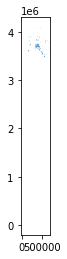

In [68]:
# get Arizona cities to break down data
cities = gpd.read_file(os.path.join(ws, 'az_cities.geojson')) #.set_crs('epsg:3785')
cities = cities.to_crs('epsg:32612')
city_lyr = cities.plot()
state_gdf.boundary.plot(ax=city_lyr, edgecolor='black')

In [69]:
# join city data to buildings (about 5 min with entire dataset)
bldgs_by_city = bldg.sjoin(cities)
phnx = bldgs_by_city[bldgs_by_city['NAME'] == 'PHOENIX']
flag = bldgs_by_city[bldgs_by_city['NAME'] == 'FLAGSTAFF']
pres = bldgs_by_city[bldgs_by_city['NAME'] == 'PRESCOTT']
tucs = bldgs_by_city[bldgs_by_city['NAME'] == 'TUCSON']



FLAGSTAFF:
mean annual precip (m):                 0.0013544647954404354
deficit under average conditions (m^3): 16.39558013363688
deficit under wettest conditions (m^3): 15.722708396619177
deficit under driest conditions (m^3):  16.578996162215088


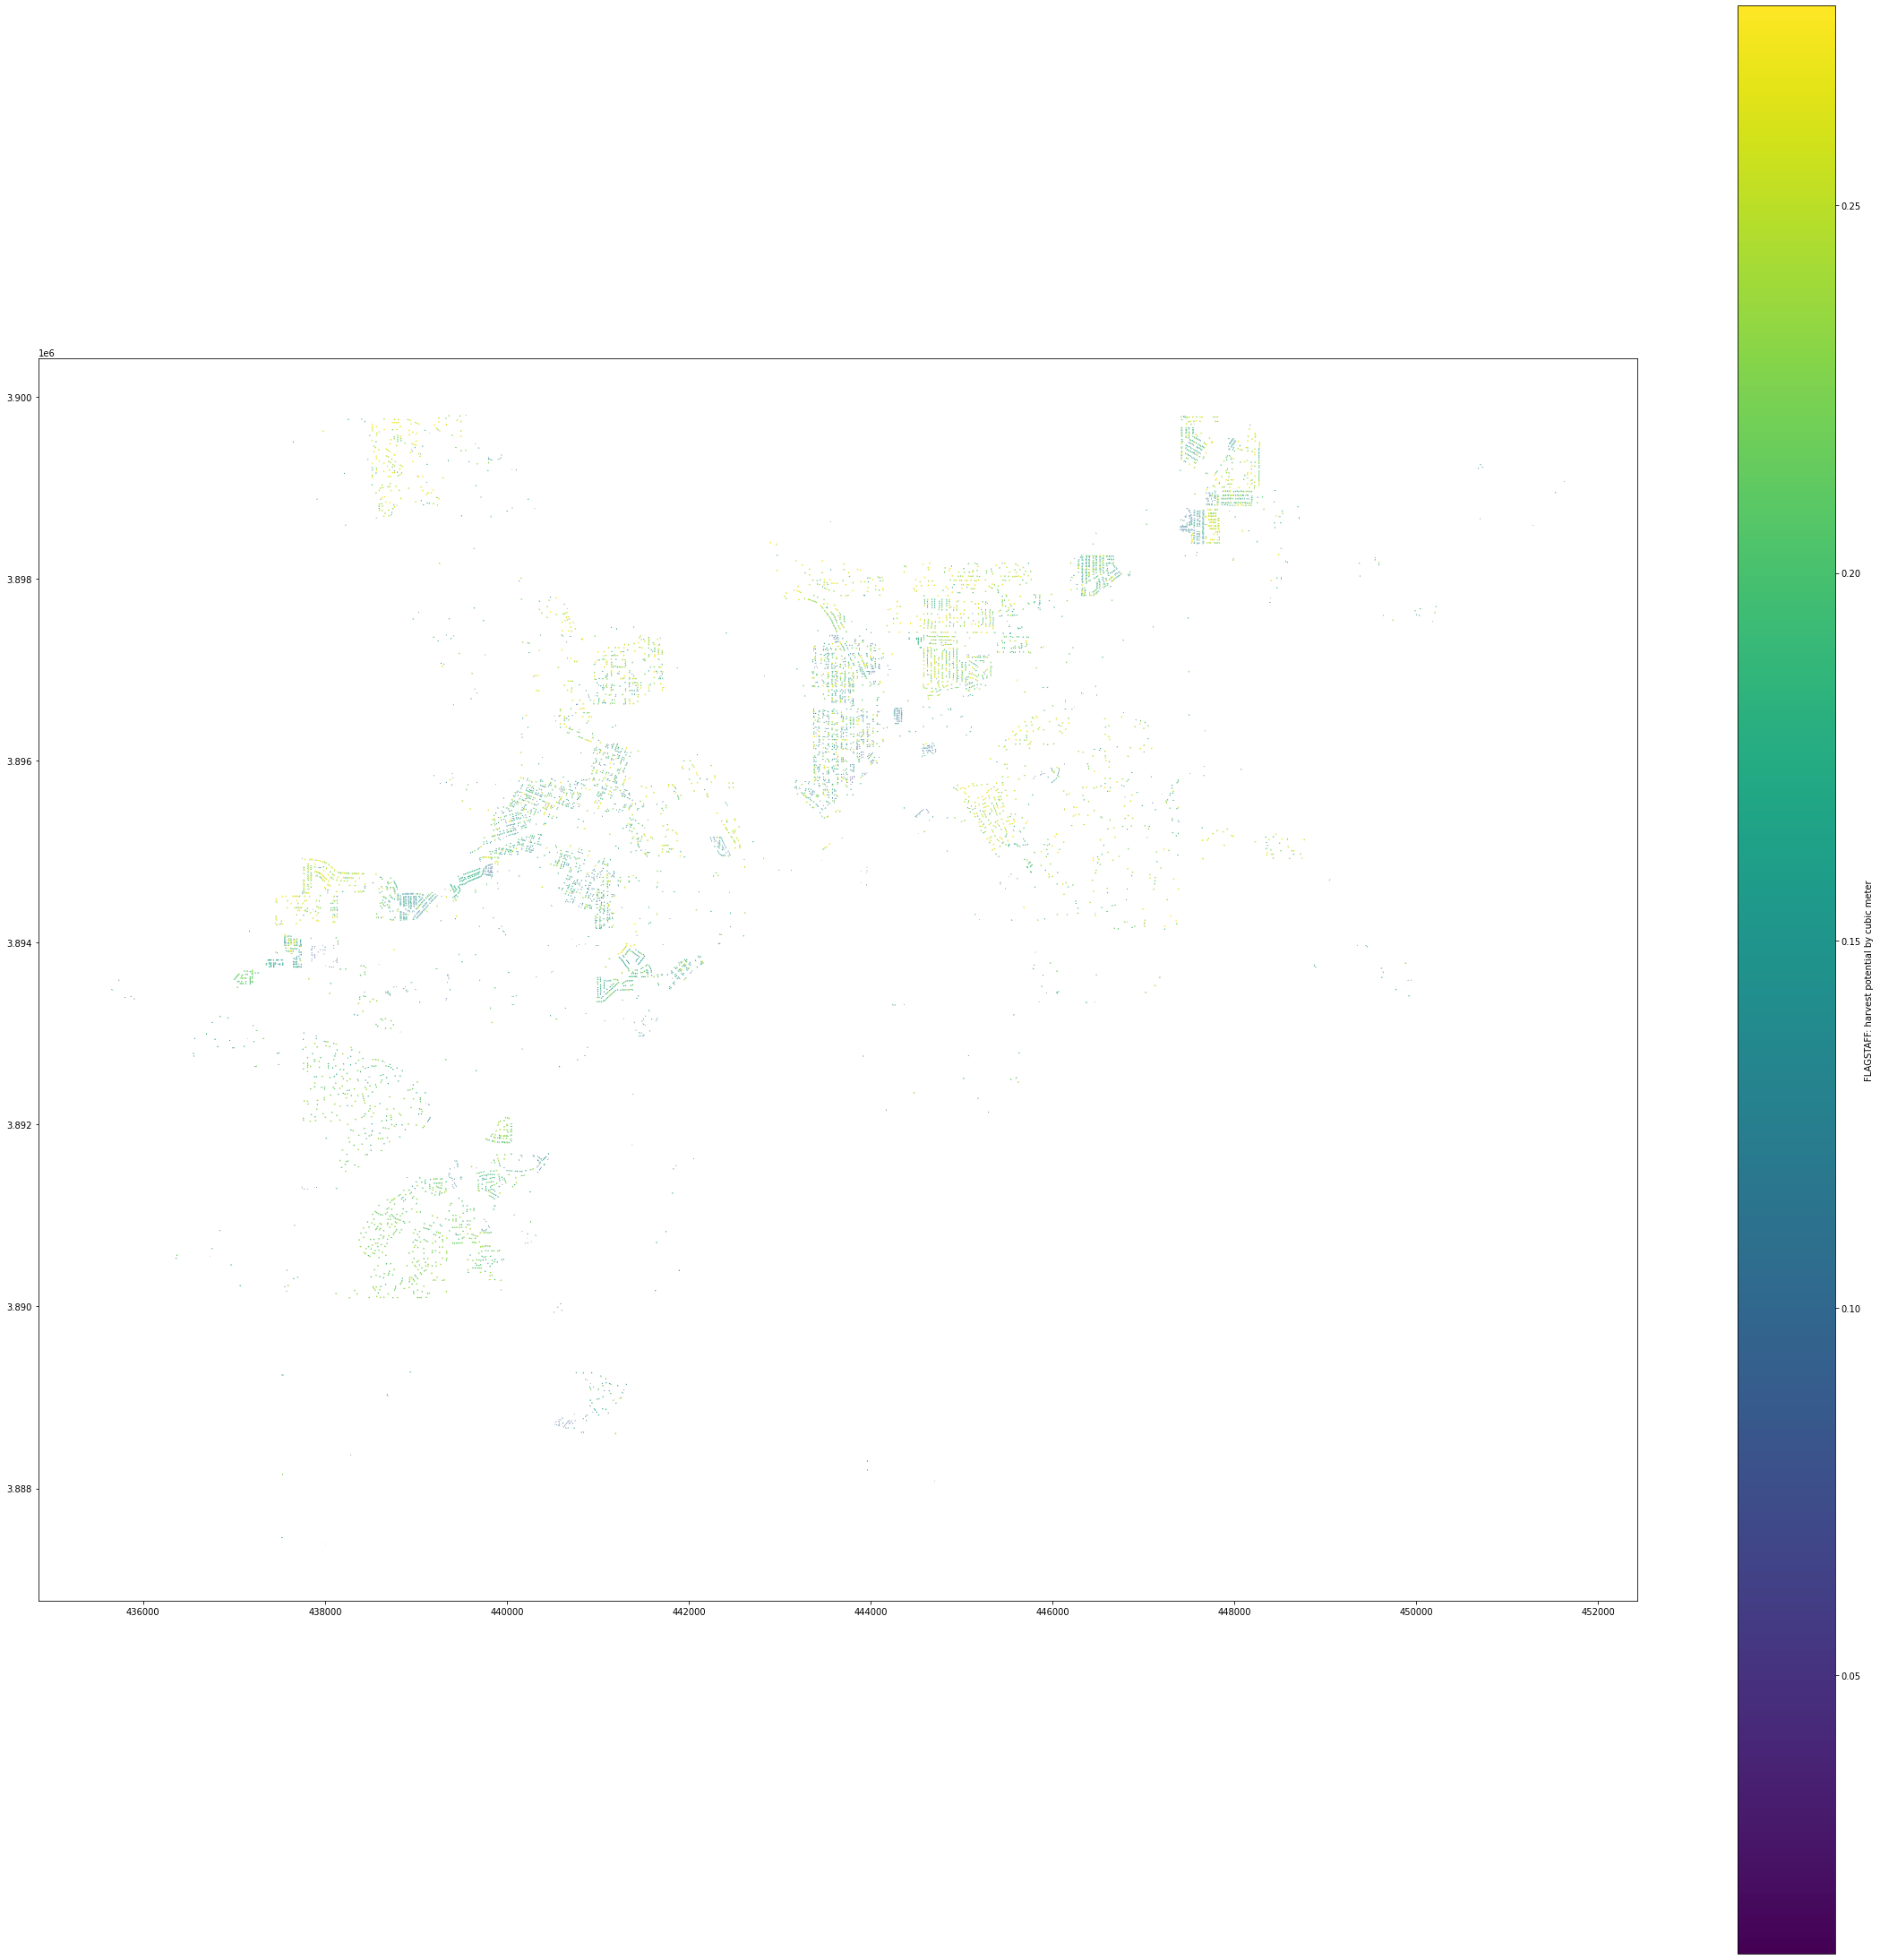

In [70]:
print("\n\nFLAGSTAFF:")
print(f'mean annual precip (m):                 {flag["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {flag["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {flag["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {flag["arid_deficit_m3"].mean()}')

flag_plt = flag.plot(column='mean_harvest_m3',
        figsize=(40, 40),
        legend=True,
        legend_kwds={'label': "FLAGSTAFF: harvest potential by cubic meter"})



PRESCOTT:
mean annual precip (m):                 0.0012923369649797678
deficit under average conditions (m^3): 16.41567892198412
deficit under wettest conditions (m^3): 15.700452679360094
deficit under driest conditions (m^3):  16.580095800000002


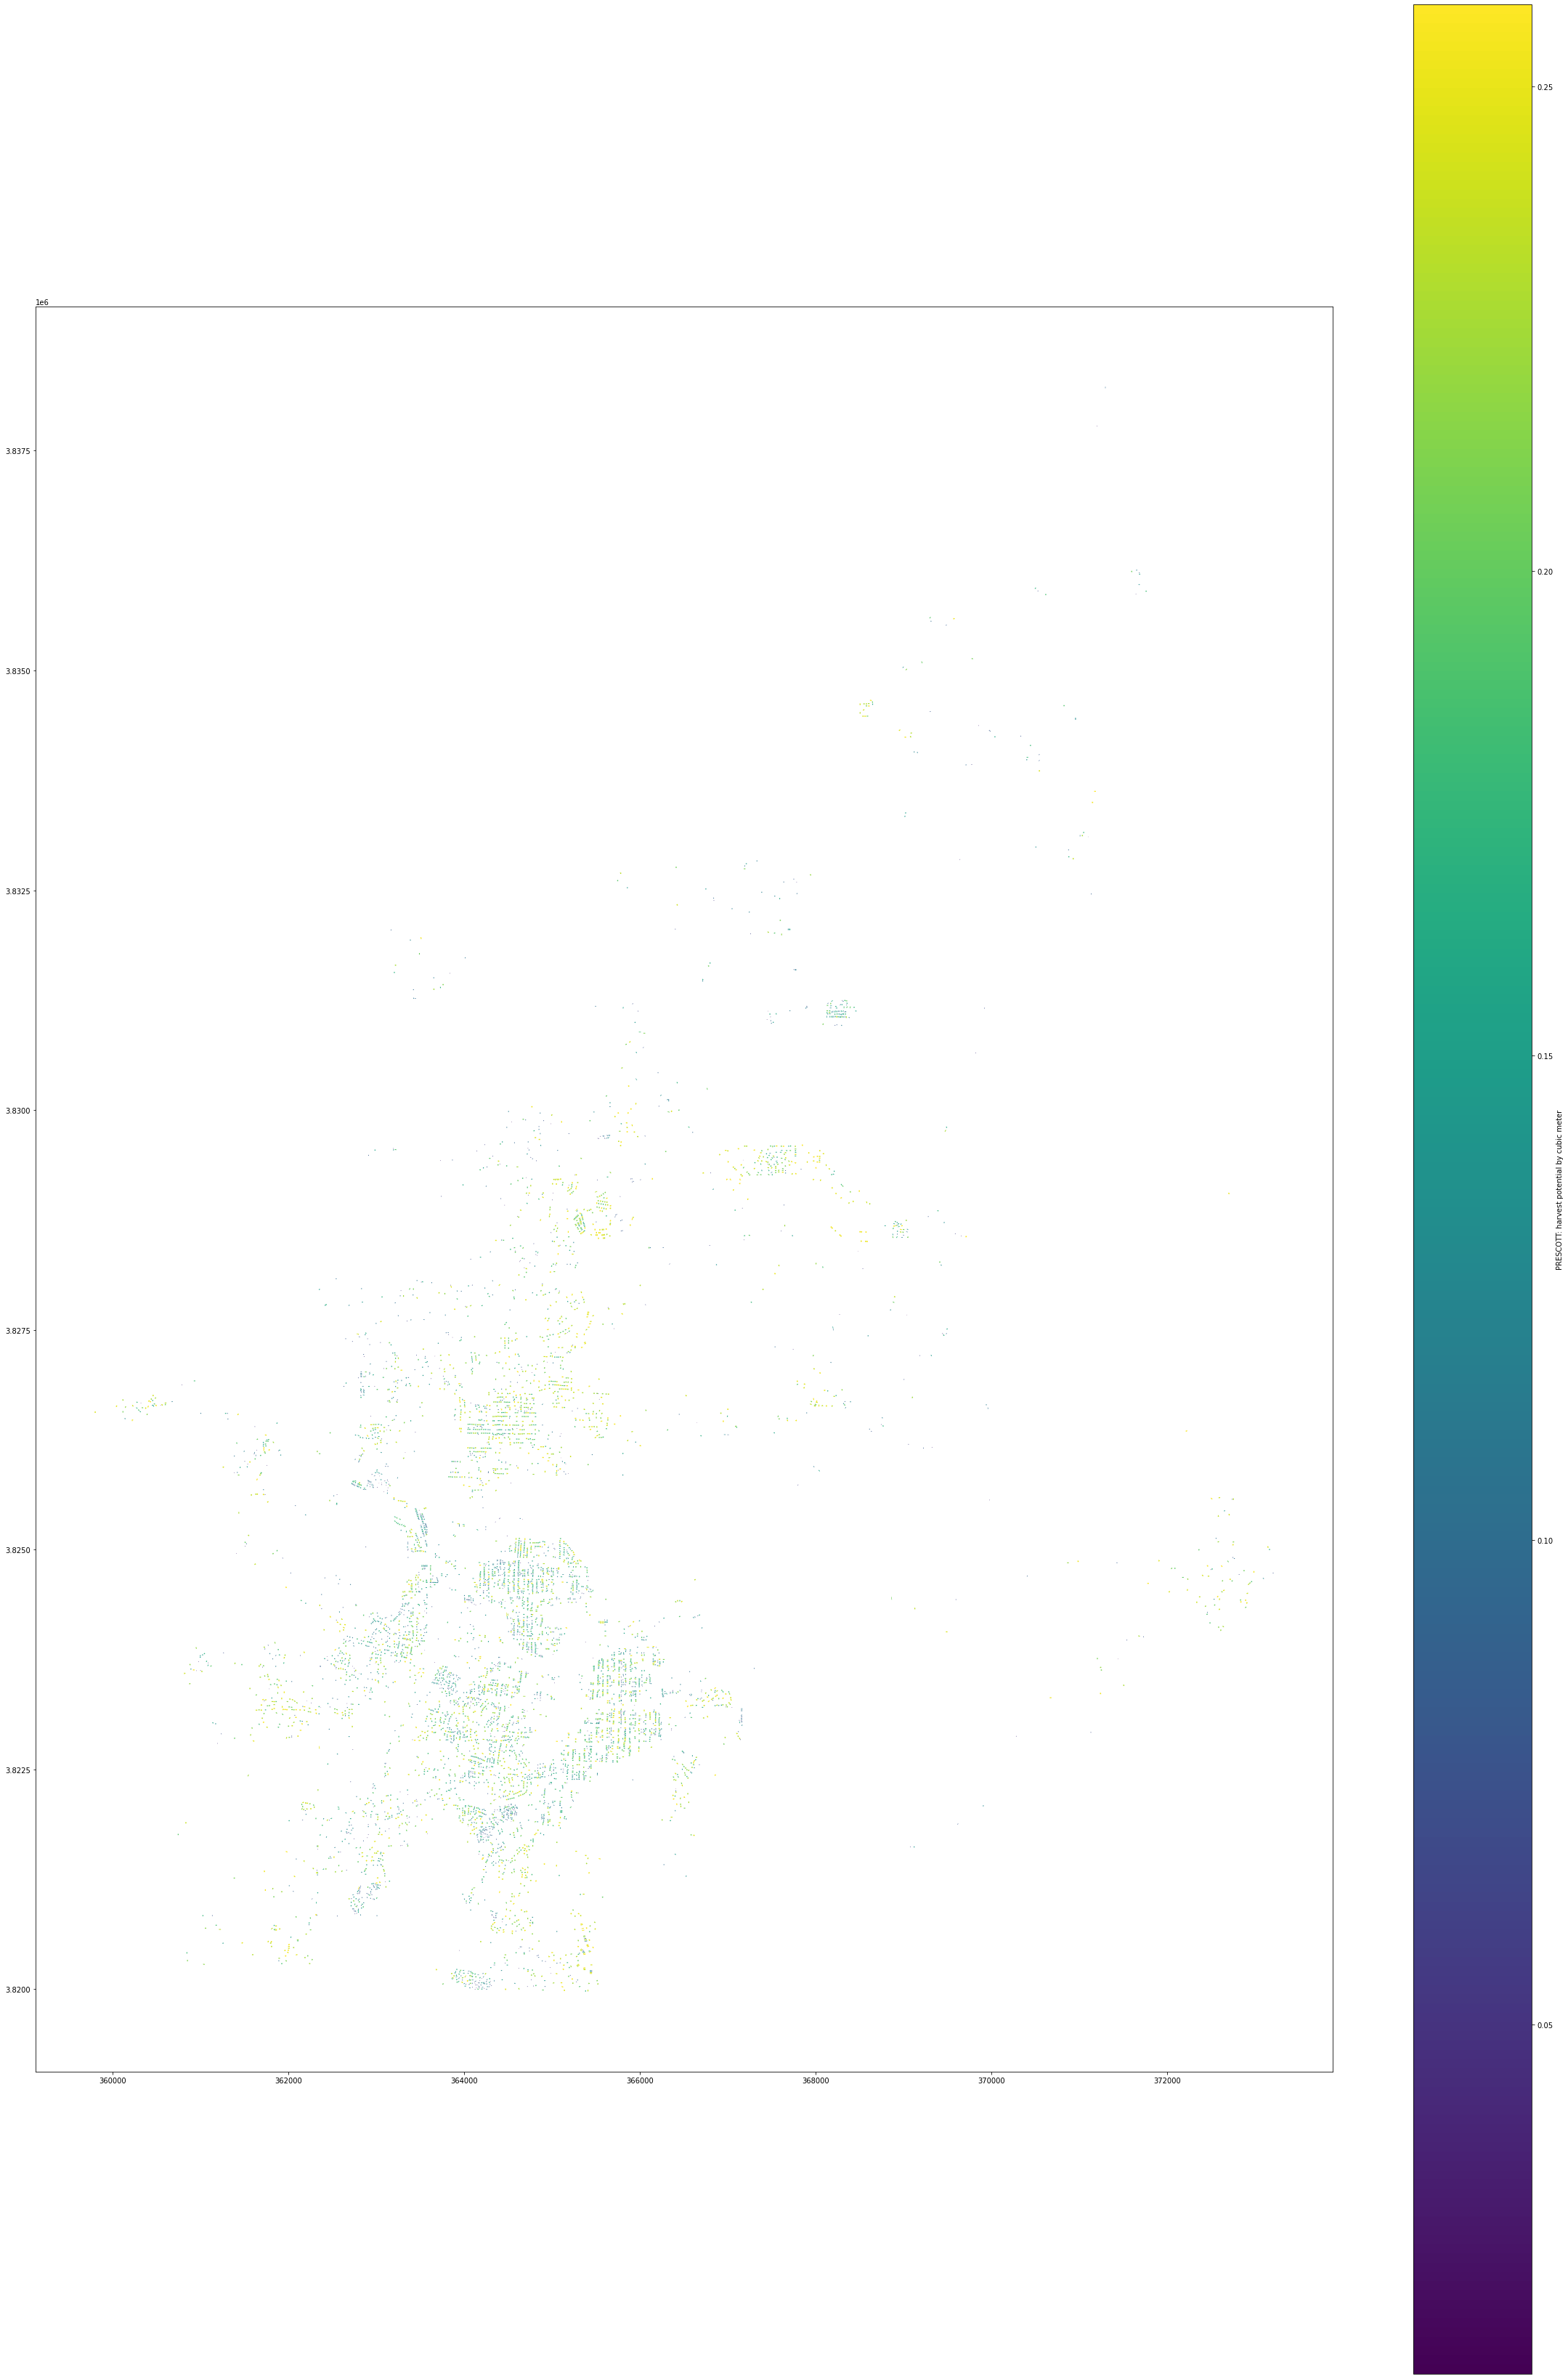

In [71]:
print("\n\nPRESCOTT:")
print(f'mean annual precip (m):                 {pres["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {pres["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {pres["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {pres["arid_deficit_m3"].mean()}')

pres_plt = pres.plot(column='mean_harvest_m3',  
           figsize=(40, 60),
           legend=True,
           legend_kwds={'label': "PRESCOTT: harvest potential by cubic meter"})



PHOENIX:
mean annual precip (m):                 0.0007493863231502473
deficit under average conditions (m^3): 16.474969039897644
deficit under wettest conditions (m^3): 16.013489588831238
deficit under driest conditions (m^3):  16.580095800000002


<AxesSubplot: >

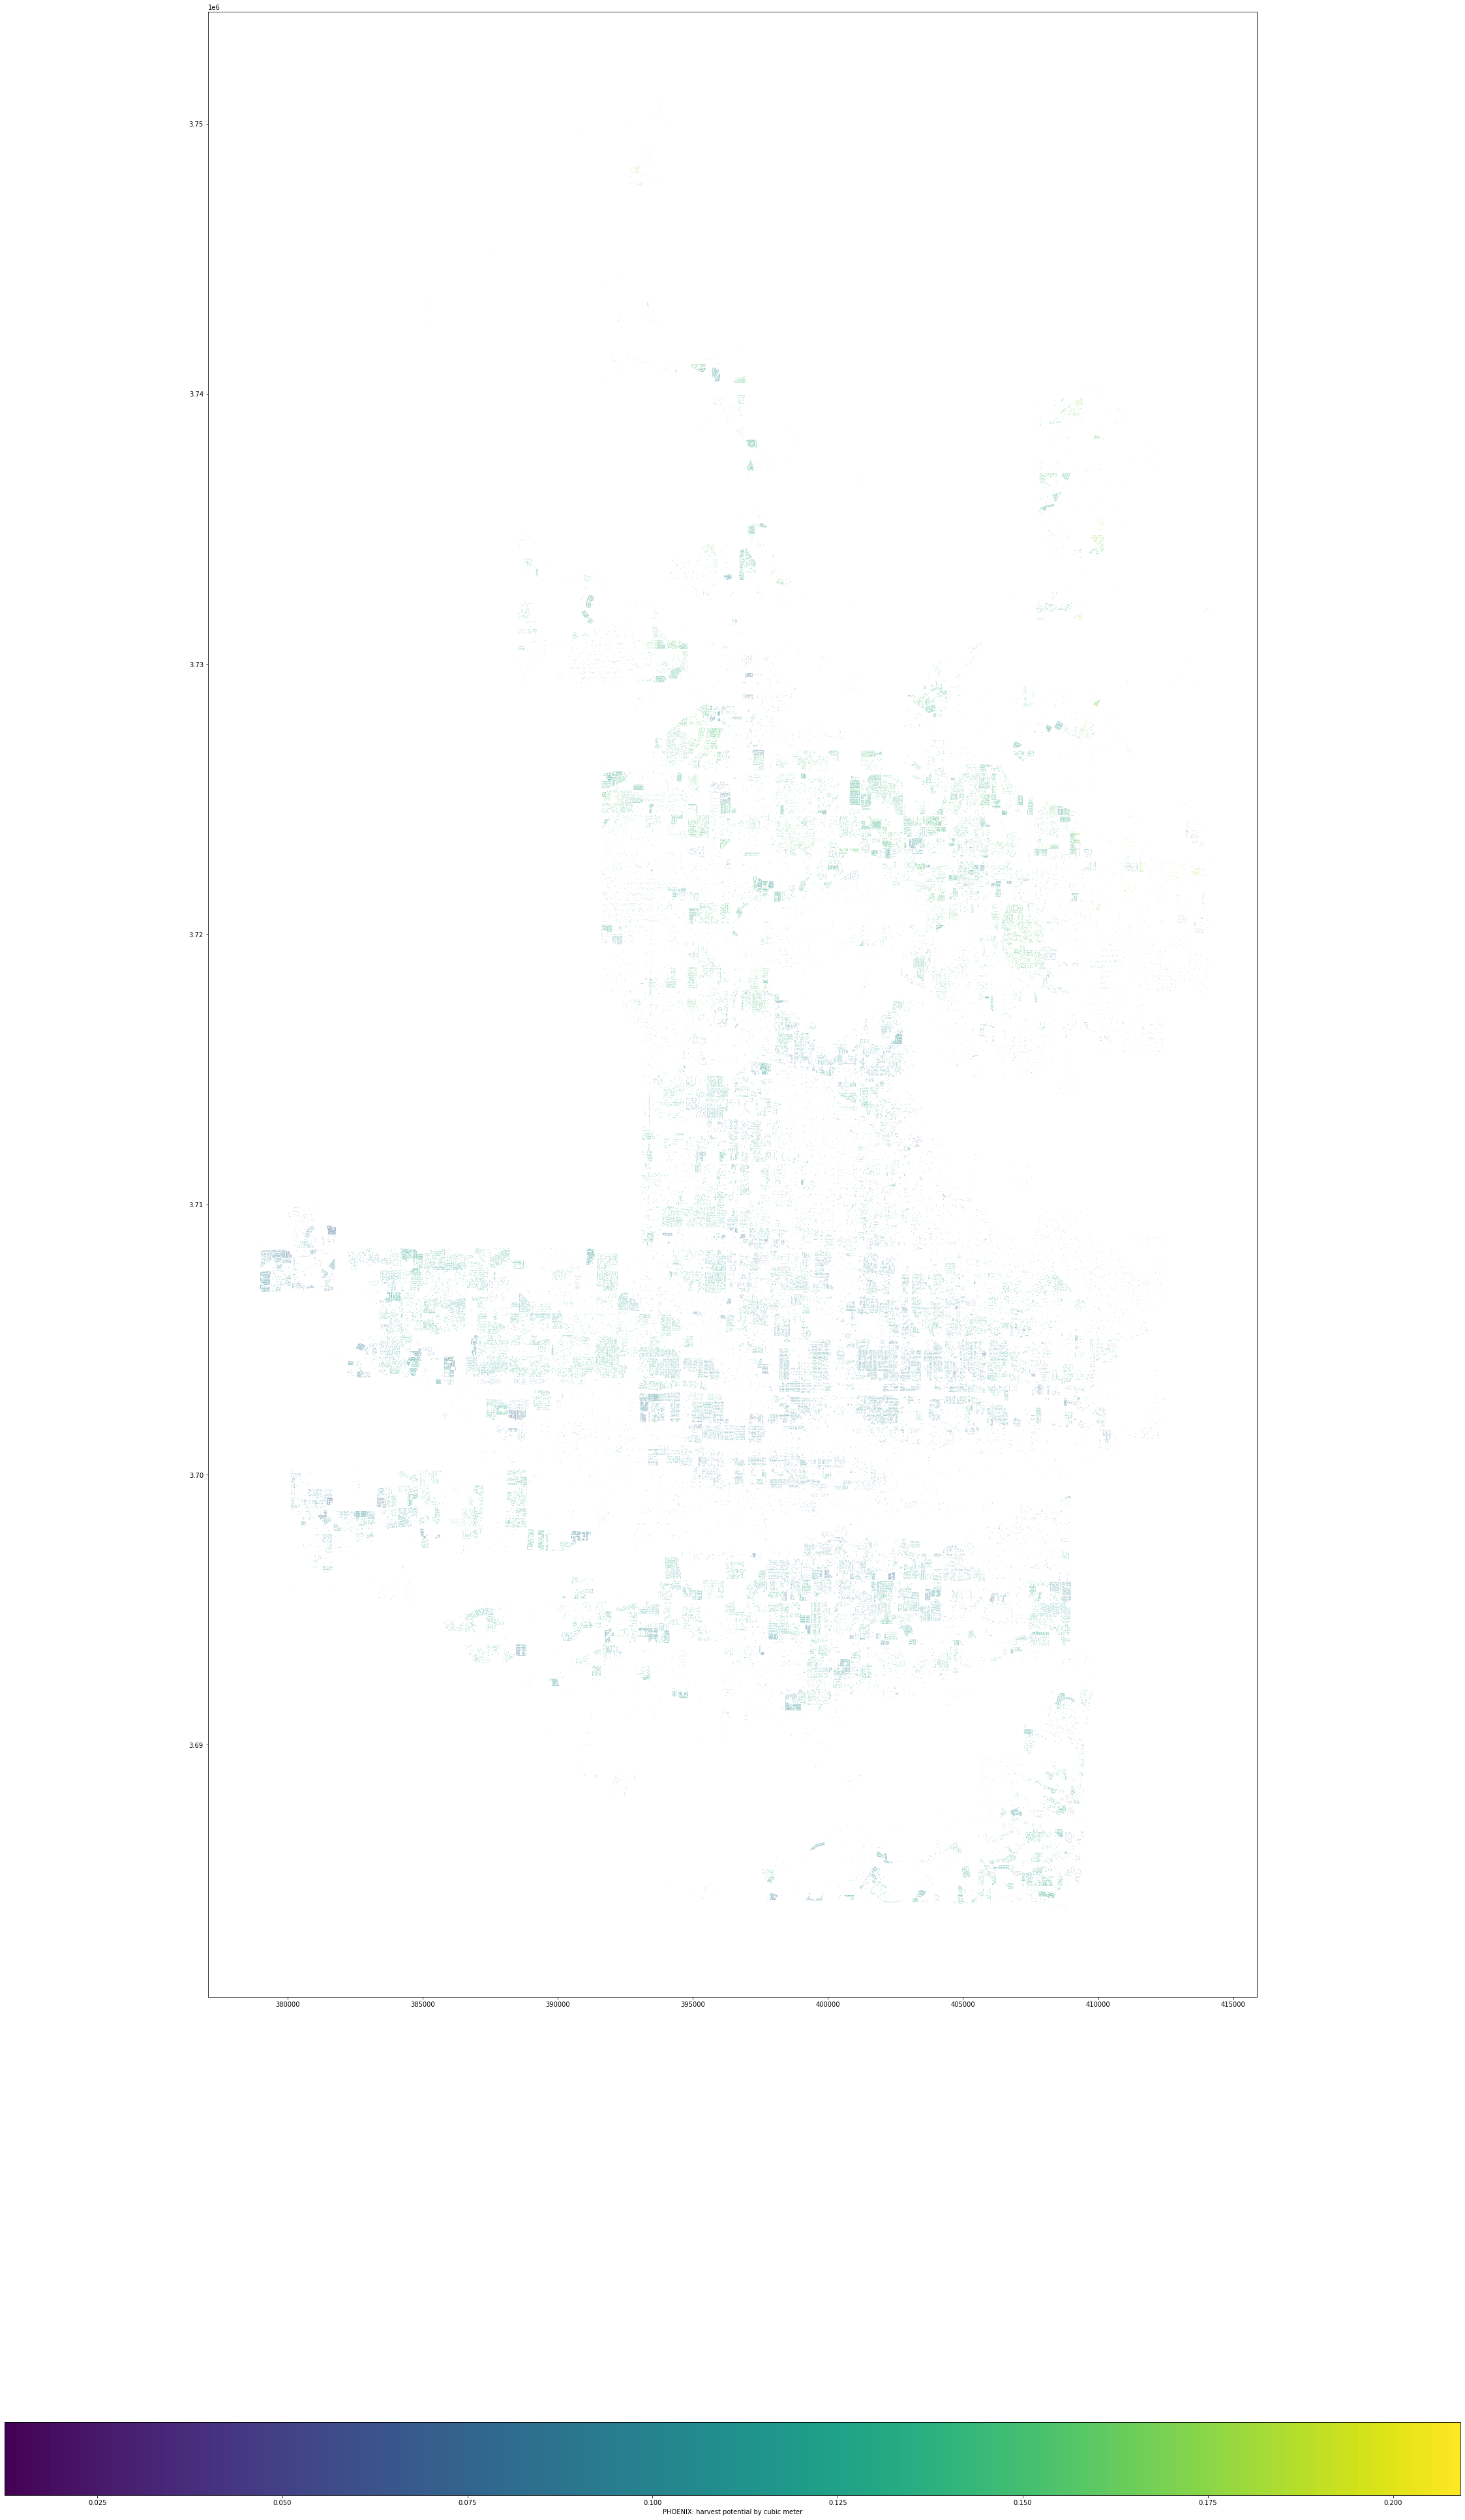

In [72]:
print("\n\nPHOENIX:")
print(f'mean annual precip (m):                 {phnx["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {phnx["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {phnx["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {phnx["arid_deficit_m3"].mean()}')

phnx.plot(column='mean_harvest_m3',
    figsize=(40, 80),
    legend=True,
    legend_kwds={
        'label': "PHOENIX: harvest potential by cubic meter",
        'orientation': "horizontal"})




TUCSON:
mean annual precip (m):                 0.0007729568751528859
deficit under average conditions (m^3): 16.476774302609794
deficit under wettest conditions (m^3): 16.01763746186984
deficit under driest conditions (m^3):  16.580095800000006


<AxesSubplot: >

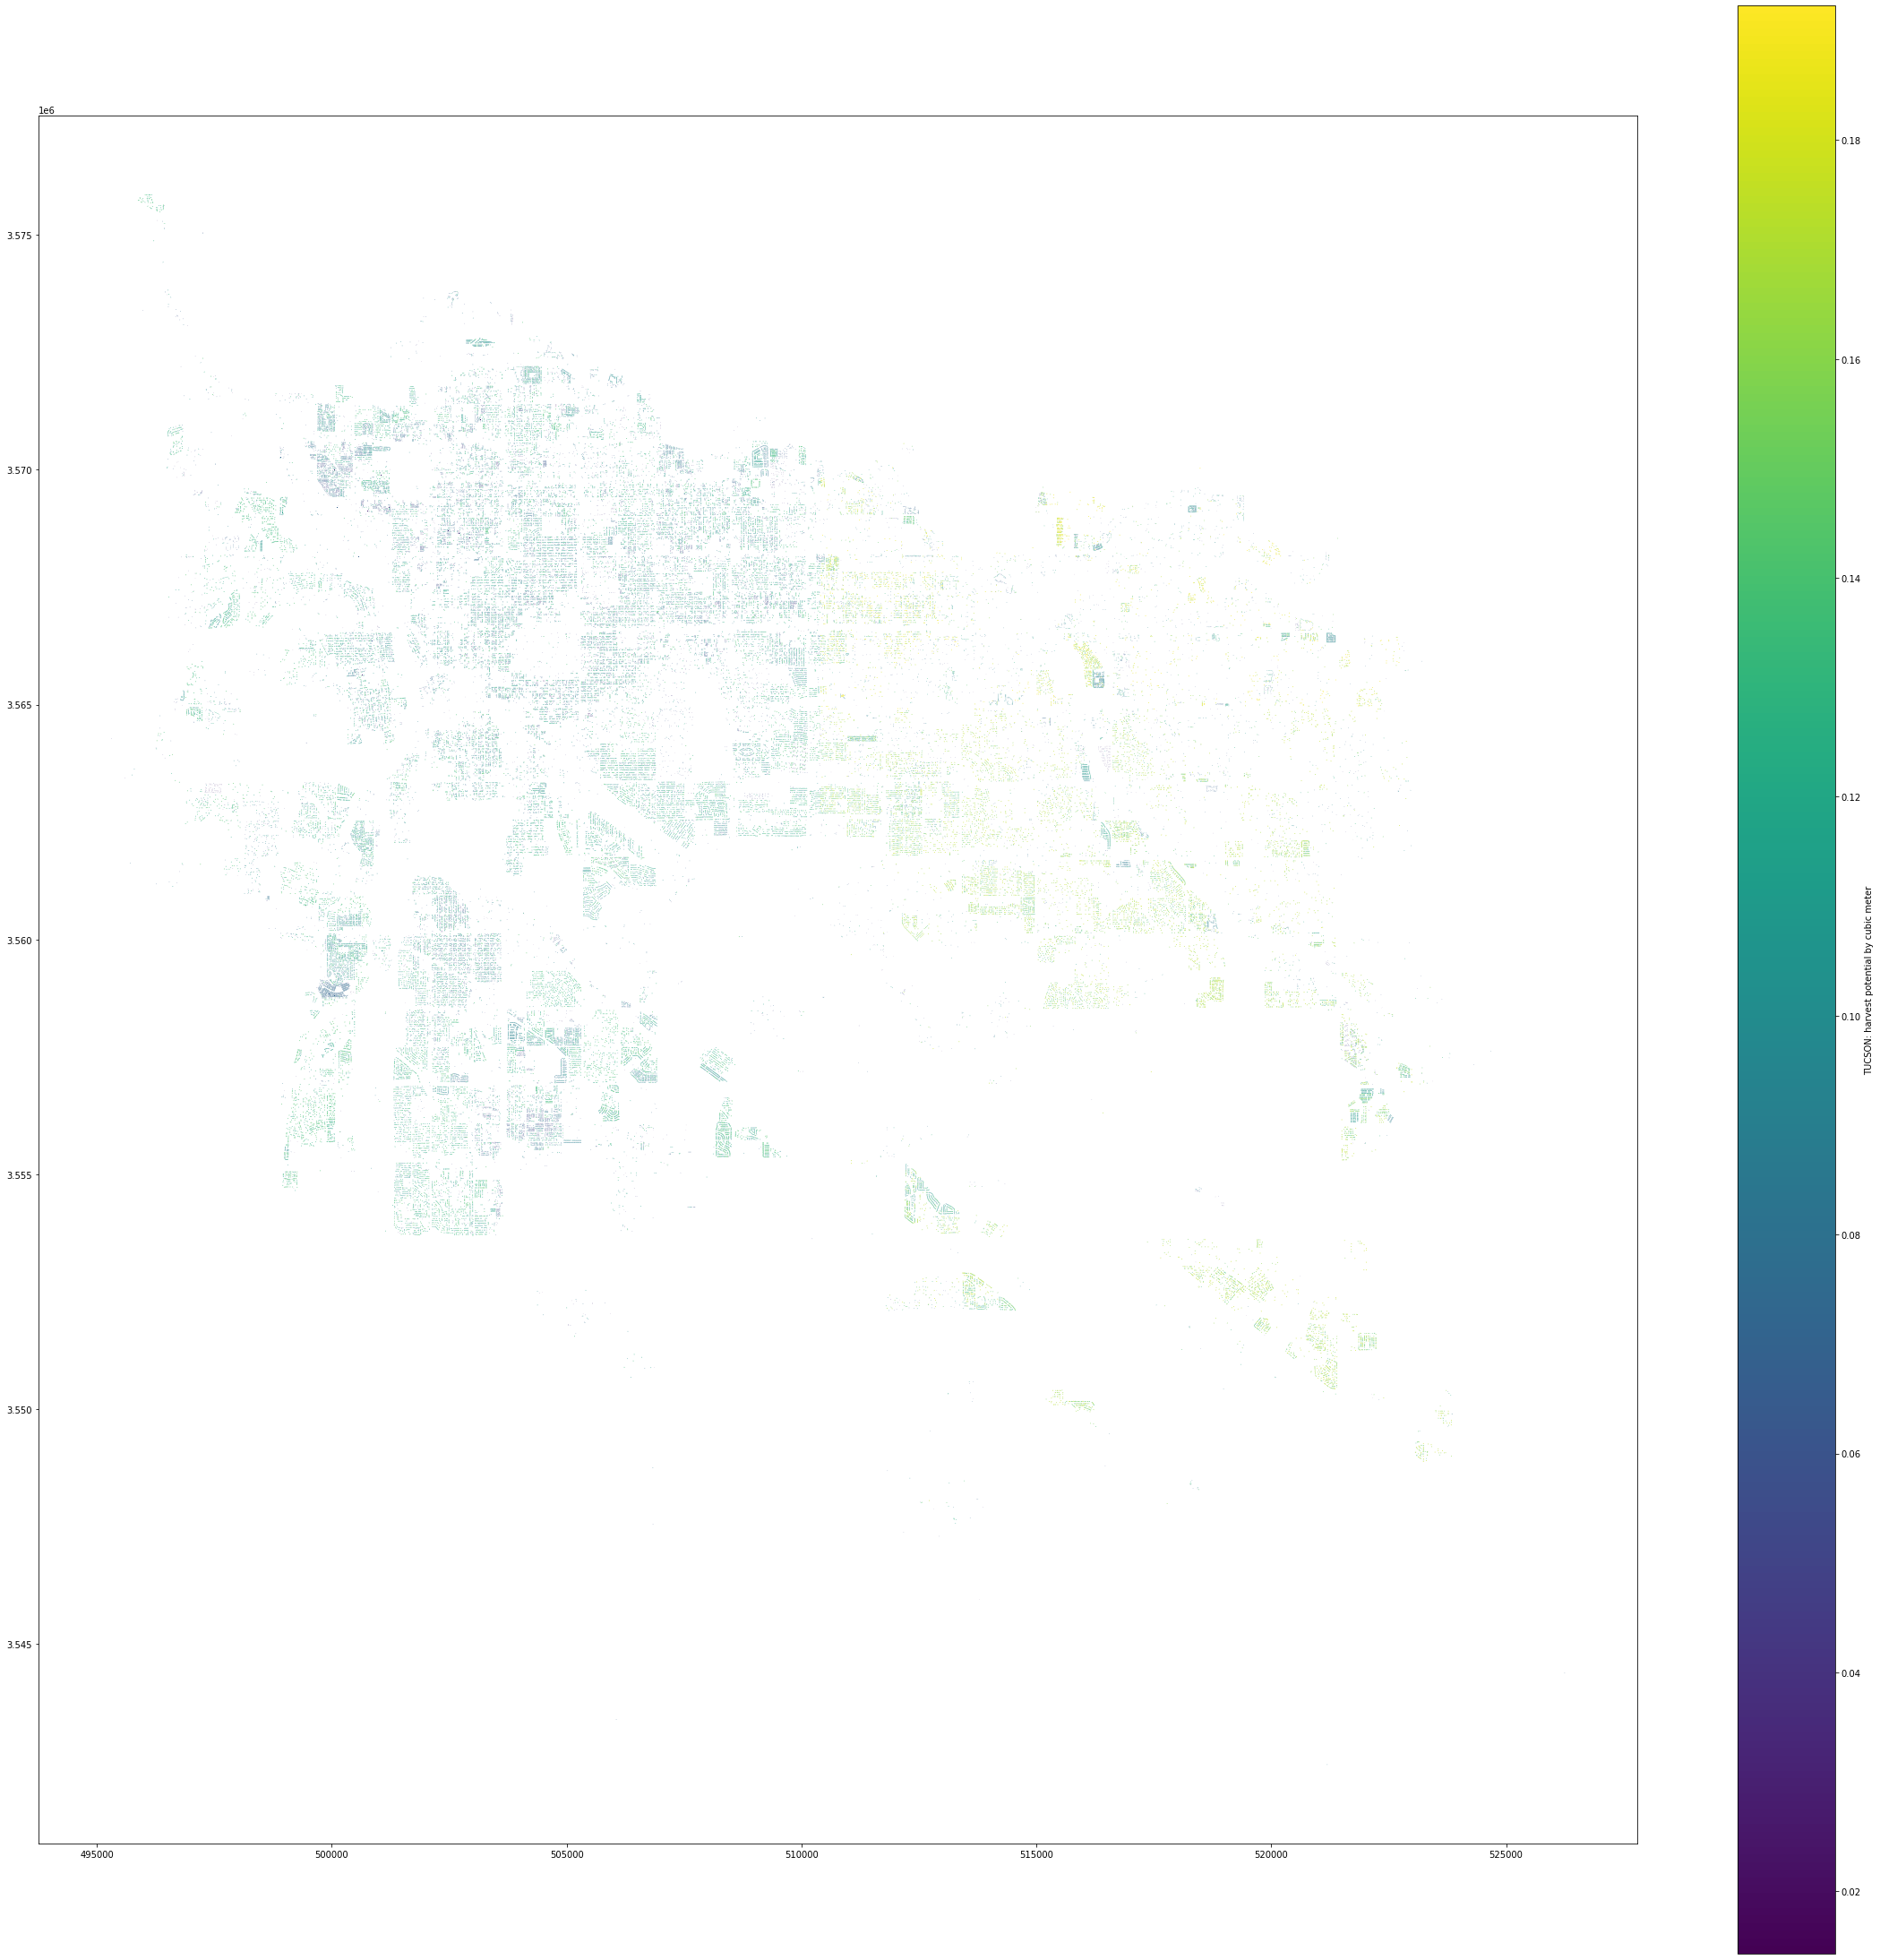

In [73]:
print("\n\nTUCSON:")
print(f'mean annual precip (m):                 {tucs["mean_precip_m"].mean()}')
print(f'deficit under average conditions (m^3): {tucs["mean_deficit_m3"].mean()}')
print(f'deficit under wettest conditions (m^3): {tucs["wet_deficit_m3"].mean()}')
print(f'deficit under driest conditions (m^3):  {tucs["arid_deficit_m3"].mean()}')

tucs.plot(column='mean_harvest_m3',  
           figsize=(40, 40),
           legend=True,
           legend_kwds={'label': "TUCSON: harvest potential by cubic meter"})


In [81]:
#We also have to get the amt water from meters cubed to gallons
#This cell finds out if each building collected 10 years worth of water over the entire 10-year period 

#phoenix
phnx['precip_adj'] = phnx['precip_m'] * phnx['area_m2']
total = []
for i in phnx['precip_adj']:
    total.append(sum(i)* 264.172)
phnx['total_10yr_gallon'] = total 
met = []
for i in phnx['total_10yr_gallon']:
    if i > (146*2.5*365*10):
        met.append(1)
    else:
        met.append(0)
phnx['met'] = met
phnx_met = phnx[phnx['met'] == 1]

#flagstaff
flag['precip_adj'] = flag['precip_m'] * flag['area_m2']
total = []
for i in flag['precip_adj']:
    total.append(sum(i)* 264.172)
flag['total_10yr_gallon'] = total 
met = []
for i in flag['total_10yr_gallon']:
    if i > (146*2.5*365*10):
        met.append(1)
    else:
        met.append(0)
flag['met'] = met
flag_met = flag[flag['met'] == 1]

#prescott
pres['precip_adj'] = pres['precip_m'] * pres['area_m2'] 
total = []
for i in pres['precip_adj']:
    total.append(sum(i)* 264.172)
pres['total_10yr_gallon'] = total 
met = []
for i in pres['total_10yr_gallon']:
    if i > (146*2.5*365*10):
        met.append(1)
    else:
        met.append(0)
pres['met'] = met
pres_met = pres[pres['met'] == 1]

#tucson
tucs['precip_adj'] = tucs['precip_m'] * tucs['area_m2']
total = []
for i in tucs['precip_adj']:
    total.append(sum(i)* 264.172)
tucs['total_10yr_gallon'] = total 
met = []
for i in tucs['total_10yr_gallon']:
    if i > (146*2.5*365*10):
        met.append(1)
    else:
        met.append(0)
tucs['met'] = met
tucs_met = tucs[tucs['met'] == 1]


C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\emers\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [82]:
print(f'{phnx_met.shape[0]} of the houses in Phoenix collected enough water from 2013-2022 to sustain themselves.')
print(f'{flag_met.shape[0]} of the houses in Flagstaff collected enough water from 2013-2022 to sustain themselves.')
print(f'{pres_met.shape[0]} of the houses in Prescott collected enough water from 2013-2022 to sustain themselves.')
print(f'{tucs_met.shape[0]} of the houses in Tucson collected enough water from 2013-2022 to sustain themselves.')

0 of the houses in Phoenix collected enough water from 2013-2022 to sustain themselves.
0 of the houses in Flagstaff collected enough water from 2013-2022 to sustain themselves.
0 of the houses in Prescott collected enough water from 2013-2022 to sustain themselves.
0 of the houses in Tucson collected enough water from 2013-2022 to sustain themselves.


Text(0.5, 1.0, 'Phoenix water collected over 10 years')

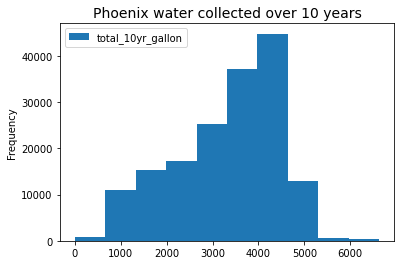

In [83]:
# Phoenix
# How much water could be collected over a the 10-year period 2013-2022
# 532,900 gallons is what an average house would use in a 10 year period

hist = phnx.plot(column='total_10yr_gallon', kind='hist')
hist.set_title("Phoenix water collected over 10 years", fontsize=14)

Text(0.5, 1.0, 'Flagstaff water collected over 10 years')

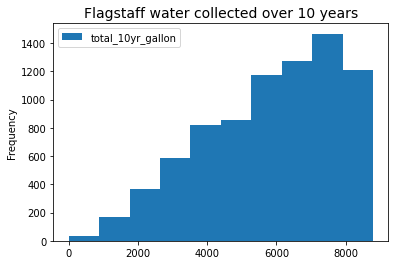

In [84]:
# Flagstaff
# How much water could be collected over a the 10-year period 2013-2022
# 532,900 gallons is what an average house would use in a 10 year period

hist = flag.plot(column='total_10yr_gallon', kind='hist')
hist.set_title("Flagstaff water collected over 10 years", fontsize=14)

Text(0.5, 1.0, 'Prescott water collected over 10 years')

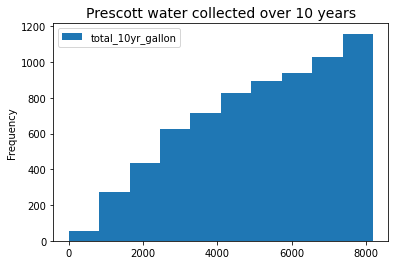

In [85]:
# Prescott
# How much water could be collected over a the 10-year period 2013-2022
# 532,900 gallons is what an average house would use in a 10 year period

hist = pres.plot(column='total_10yr_gallon', kind='hist')
hist.set_title("Prescott water collected over 10 years", fontsize=14)

Text(0.5, 1.0, 'Tucson water collected over 10 years')

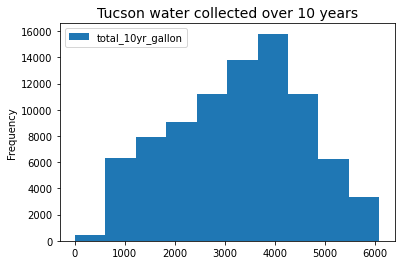

In [86]:
# Tucson
# How much water could be collected over a the 10-year period 2013-2022
# 532,900 gallons is what an average house would use in a 10 year period

hist = tucs.plot(column='total_10yr_gallon', kind='hist')
hist.set_title("Tucson water collected over 10 years", fontsize=14)

As you can see, even the houses that collected the most water had nowhere near enought to meet Arizona's average water usage.

In [100]:
print('HOW TO INTERPRET THIS:\n')
print('deficit under average conditions: in an average month, how far away the average house would be from meeting its water needs\n')
print('deficit under wettest conditions: in the wettest month over the 10-year period, how far away the average house would be from \nmeeting its water needs\n')
print('deficit under driest conditions: in the driest month over the 10-year period, how far away the average house would be from \nmeeting its water needs')

print("\n\nPHOENIX:")
print(f'mean monthly precip (mm):                 {phnx["mean_precip_m"].mean()*1000:.2f}')
print(f'deficit under average conditions (gallons): {phnx["mean_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under wettest conditions (gallons): {phnx["wet_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under driest conditions (gallons):  {phnx["arid_deficit_m3"].mean()*264.172*2.5:.2f}')

print("\n\nFLAGSTAFF:")
print(f'mean monthly precip (mm):                 {flag["mean_precip_m"].mean()*1000:.2f}')
print(f'deficit under average conditions (gallons): {flag["mean_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under wettest conditions (gallons): {flag["wet_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under driest conditions (gallons):  {flag["arid_deficit_m3"].mean()*264.172*2.5:.2f}')

print("\n\nPRESCOTT:")
print(f'mean monthly precip (mm):                 {pres["mean_precip_m"].mean()*1000:.2f}')
print(f'deficit under average conditions (gallons): {pres["mean_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under wettest conditions (gallons): {pres["wet_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under driest conditions (gallons):  {pres["arid_deficit_m3"].mean()*264.172*2.5:.2f}')

print("\n\nTUCSON:")
print(f'mean monthly precip (mm):                 {tucs["mean_precip_m"].mean()*1000:.2f}')
print(f'deficit under average conditions (gallons): {tucs["mean_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under wettest conditions (gallons): {tucs["wet_deficit_m3"].mean()*264.172*2.5:.2f}')
print(f'deficit under driest conditions (gallons):  {tucs["arid_deficit_m3"].mean()*264.172*2.5:.2f}')

HOW TO INTERPRET THIS:

deficit under average conditions: in an average month, how far away the average house would be from meeting its water needs

deficit under wettest conditions: in the wettest month over the 10-year period, how far away the average house would be from 
meeting its water needs

deficit under driest conditions: in the driest month over the 10-year period, how far away the average house would be from 
meeting its water needs


PHOENIX:
mean monthly precip (mm):                 0.75
deficit under average conditions (gallons): 10880.56
deficit under wettest conditions (gallons): 10575.79
deficit under driest conditions (gallons):  10949.99


FLAGSTAFF:
mean monthly precip (mm):                 1.35
deficit under average conditions (gallons): 10828.13
deficit under wettest conditions (gallons): 10383.75
deficit under driest conditions (gallons):  10949.27


PRESCOTT:
mean monthly precip (mm):                 1.29
deficit under average conditions (gallons): 10841.41
defi